In [24]:
#!pip install pandas numpy matplotlib yfinance ipywidgets==8.0.6

In [35]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import yfinance as yf
import ipywidgets as widgets
from datetime import datetime, timedelta
import os

## Functions

Define useful functions to work with datasets properly:

In [36]:
# ------------------------------------------------------------------------------------------------------------------
# READ DATA
# ------------------------------------------------------------------------------------------------------------------
def read_dataset(index, interval, start_year, save=False, force_download=False):
    yf_tickers = {'sp500': '^GSPC', 'nasdaq': 'QQQ'}
    yf_intervals = {'daily': '1d', 'monthly': '1mo'}
    dataset_path = f"{index}_daily_{start_year}_2025.csv"

    # First check if CSV file with the data already exists
    if not force_download and os.path.exists(dataset_path):
        df = pd.read_csv(dataset_path, index_col=0)
        df['Date'] = pd.to_datetime(df['Date'])
    else:
        # Check that the index is currently supported for Yahoo Finance
        if index not in yf_tickers:
            raise ValueError(f"Index {index} is not supported")
    
        # Download dataset from Yahoo Finance
        df = yf.download(yf_tickers[index], start=f'{start_year}-01-01', interval=yf_intervals.get(interval, "1d"), auto_adjust=False)
    
        # Clean dataset
        df = df.reset_index() # Set date as another column
        df.columns = df.columns.get_level_values(0) # Remove MultiIndex for ticker
        df.columns.name = None
        df['Date'] = pd.to_datetime(df['Date'])
        older_date = df['Date'].min()
        df['Days'] = (df['Date'] - older_date).dt.days
    
        # Save dataset if specified
        if save:
            df.to_csv(dataset_path)
    
    return df

# ------------------------------------------------------------------------------------------------------------------
# FILTER DATA
# ------------------------------------------------------------------------------------------------------------------
def filter_dataset_by_period(df, period_start, period_end):
    start = datetime.strptime(period_start, "%Y-%m-%d")
    end = datetime.strptime(period_end, "%Y-%m-%d")
    return df[df['Date'].between(start, end)]

def filter_dataset_by_days(df, days_start, days_end):
    return df[df['Days'].between(days_start, days_end)]

# ------------------------------------------------------------------------------------------------------------------
# PLOT DATA
# ------------------------------------------------------------------------------------------------------------------
def plot_dataset(df):
    plt.figure()
    ax = plt.gca()
    ax.plot(df['Date'], df['Adj Close'])

    # Format dates properly to avoid overlaping in short periods
    locator = mdates.AutoDateLocator(minticks=3, maxticks=8)
    formatter = mdates.ConciseDateFormatter(locator)
    ax.xaxis.set_major_locator(locator)
    ax.xaxis.set_major_formatter(formatter)
    
    plt.tight_layout()
    plt.show()

def plot_dataset_period(dataset, range_dates):
    start, end = range_dates
    plot_dataset(filter_dataset_by_period(dataset, start, end))
    
def make_range_slider_from_df_column(df, column):
    if column == "Days":
        max_day = df["Days"].max()
        return widgets.IntRangeSlider(
            value=(0, max_day), 
            min=0, 
            max=max_day, 
            step=1,
            description='Days', 
            readout=True, 
            readout_format='d',
            continuous_update=False, 
            layout={"width": "100%", "height": "80px"}
        )
    if column == "Date":
        dates = df['Date'].astype(str)
        unique_sorted = sorted(set(dates))
        return widgets.SelectionRangeSlider(
            options=unique_sorted,
            index=(0, len(unique_sorted)-1),
            description="Dates Range",
            orientation="horizontal",
            continuous_update=False,
            layout={"width": "100%", "height": "80px"}
        )
    raise ValueError(f"Column '{column}' not supported to create range slider")

def plot_dataset_interactive(dataset, column="Date"):
    range_slider = make_range_slider_from_df_column(dataset, column)
    def _plot(range_dates):
        start, end = range_dates
        if column == "Date":
            plot_dataset(filter_dataset_by_period(dataset, start, end))
        if column == "Days":
            plot_dataset(filter_dataset_by_days(dataset, start, end))
    return widgets.interact(_plot, range_dates=range_slider)


def leverage_dataset(_df, L=5, knockout_zero=True):
    # Get prices from original dataset as a Pandas Series
    prices = pd.Series(_df["Adj Close"])
    # Create new Series with the price percentage change (daily returns)
    daily_returns = prices.pct_change().fillna(0.0)
    # Compute leveraged performance
    leveraged_daily_returns = L * daily_returns
    # Add base 1 to make compounding effect
    factor = 1 + leveraged_daily_returns
    
    if knockout_zero:
        # Look for negative returns and limit them to zero
        factor = factor.where(factor > 0.0, 0.0)
        # Create a mask with the first value equal to zero
        # Use cummax to ensure all values after first 0 are included
        zero_mask = (factor == 0.0).cummax()
        # After ETP arrives value 0, it "dissappears"
        factor[zero_mask] = 0.0
        
    # Get initial price from original dataset
    initial_nav = _df['Adj Close'].iloc[0]
    # Accumulate all the performances starting on initial price (compound effect)
    nav = initial_nav * factor.cumprod()
    
    return pd.DataFrame({"Date": _df["Date"], "Days": _df["Days"], "Og Adj Close": _df['Close'], "Adj Close": nav})

## Leverage investment strategy


In [41]:
class Asset:

    def __init__(self, ticker, prices, max_eur):
        self.ticker = ticker
        self.prices = prices
        self.max_eur = max_eur
        self.invested_eur = 0
        self.invested_qty = 0
        self.invested_value = 0
        self.buys = []

    def __create_buy(self, t, amount, qty):
        return {
            "index": t,
            "ticker": self.ticker,
            "price": self.prices[t], 
            "amount": amount, 
            "qty": qty,
            "yield_target": 0.5 if "x2" in self.ticker else 1.0,
            "invested_eur": self.invested_eur, 
            "pending_until_max": max(self.max_eur - self.invested_eur, 0)
        }

    @staticmethod
    def __print_buy(buy_item):
        print("************************ BUY ************************")
        print(f"{'Buy time':<30}: {buy_item['index']:>10}")
        print(f"{'Ticker':<30}: {buy_item['ticker']:>10}")
        print(f"{'Price':<30}: {buy_item['price']:>10.2f}")
        print(f"{'Amount':<30}: {buy_item['amount']:>10.2f}")
        print(f"{'Quantity':<30}: {buy_item['qty']:>10.2f}")
        print(f"{'Yield target':<30}: {buy_item['yield_target']:>10.2f}")
        print(f"{'Invested EUR (after buy)':<30}: {buy_item['invested_eur']:>10.2f}")
        print(f"{'Pending until max':<30}: {buy_item['pending_until_max']:>10.2f}")
        print("*****************************************************")

    def get_ticker():
        return self.ticker
    
    def get_invested_eur(self):
        return self.invested_eur

    def get_buys(self):
        return self.buys

    def get_extra_cash(self):
        return max(self.invested_eur - self.max_eur, 0)

    def __add_buy(self, amount_eur, t):
        # Compute invested qty
        # TODO: Compute real amount because we cannot invest fractional amounts
        qty = amount_eur / self.prices[t]

        # Update cummulative amounts
        self.invested_eur += amount_eur
        self.invested_qty += qty
        self.invested_value = self.prices[t] * self.invested_qty

        # Create and add buy
        self.buys.append(self.__create_buy(t, amount_eur, qty))

    # Buy shares using cash
    def buy(self, amount_eur, t):
        # Check investment upper limit is not surpassed
        if self.invested_eur + amount_eur > self.max_eur:
            raise ValueError(f"Trying to buy more than {self.max_eur} of {self.ticker} using cash. Aborting...")

        # Add buy
        self.__add_buy(amount_eur, t)
        
        # Print buy info
        print(f"Using cash to buy {amount_eur}€ of {self.ticker}")
        self.__print_buy(self.buys[-1])
    
    # Buy shares by rotating from higher leverage factors
    def rotate_buy(self, from_ticker, amount_eur, t):
        # Add buy
        self.__add_buy(amount_eur, t)
        
        # Print buy info
        print(f"Rotating {amount_eur}€ from {from_ticker} to {self.ticker}")
        self.__print_buy(self.buys[-1])

    # Sell shares to rotate to higher leverage factors
    def rotate_down_sell(self, to_ticker, amount_eur, t):
        if amount_eur > self.invested_value:
            raise ValueError(f"Trying to rotate {amount_eur} from {self.ticker} to {to_ticker} but current invested value is lower: {self.invested_value}")
        pending_amount = amount_eur
        current_price = self.prices[t]
        while pending_amount > 0.0:
            next_buy = self.buys[0] # FIFO
            buy_value = current_price * next_buy['qty']
            sell_amount = min(buy_value, pending_amount)
            sell_qty = sell_amount / current_price
            if sell_amount >= buy_value:
                print(f"SELL @ticker{ticker} @buy_price={next_buy['price']} @buy_time{next_buy['index']} @sell_price{current_price} @sell_time{t}")
                del self.buys[0]
            else:
                print(f"PARTIAL SELL @ticker{ticker} @buy_price={next_buy['price']} @buy_time{next_buy['index']} @sell_price{current_price} @sell_time{t}")
                self.buys[0]['qty'] -= sell_qty
                self.buys[0]['amount'] = self.buys[0]['qty'] * self.buys[0]['price']

            self.invested_eur -= sell_amount
            self.invested_qty -= sell_qty
            self.invested_value = current_price * self.invested_qty
            pending_amount -= sell_amount
                 

    def sell_by_index(self, idx, t):
        target_trade = self.buys[idx]
        qty = target_trade['qty']
        buy_price = target_trade['price']
        current_price = self.prices[t]
        target_yield = target_trade['yield_target']
        final_yield = (current_price / buy_price) - 1
        initial_amount = target_trade['amount']
        final_amount =current_price * qty
        buy_time = target_trade['index']

        self.invested_eur -= initial_amount
        self.invested_qty -= qty
        self.invested_value = current_price * self.invested_qty
        
        print(f"SELL @ticker {self.ticker} @qty {qty} @buy_price {buy_price} @buy_time {buy_time} @sell_price {current_price} sell_time {t} @yield {final_yield} @target_yield {target_yield}")
        del self.buys[idx]
        
        return final_amount

    def check_buys_yields(self, t):
        buys_ready = {}
        current_price = self.prices[t]
        for i, buy in enumerate(self.buys):
            if (current_price / buy['price']) - 1 > buy['yield_target']:
                buys_ready[i] = buy
        return buys_ready
        

        

In [42]:
MAX_PCTS = {"x2": 0.20, "x3": 0.80}

def check_current_dd(total_eur, dd, entry_thresholds):
    # Get the percentage of total capital that should be invested in each type of asset for current drawdown
    buy_amounts = {}
    for pct, (buy_pct, buy_type) in entry_thresholds.items():
        if pct > dd:
            max_eur = MAX_PCTS[buy_type] * total_eur
            buy_amounts[buy_type] = min(max(buy_amounts.get(buy_type, 0), buy_pct * total_eur), max_eur)
        else: 
            break

    return buy_amounts

def get_prev_factor(lev_factor):
    # WARNING! Workaround to work only with x2 and x3
    if lev_factor == "x3":
        return "x2"
    return None

def compute_drawdowns(df):
    price = df['Adj Close'].to_numpy(dtype=np.float64)
    ath = np.maximum.accumulate(price)

    # dd will have negative values or 0.0, which means this price is an ATH, as price/ATH - 1 = 0 only if price=ATH
    dd = price / ath - 1.0
    dd_df = df["Adj Close"].div(ath).sub(1.0)

    # Take values equal to 0 (ATH), that come from a previous non-zero value (drowdown), which means a recover drom a drodown
    # This df will contain True when we arrive an ATH from a previous dd
    val_is_zero = np.where(dd == 0.0, True, False)
    shifted_array = np.append(np.inf, dd[:-1])
    previous_val_not_zero = np.where(shifted_array != 0.0, True, False)
    new_ath = np.logical_and(val_is_zero, previous_val_not_zero)

    # Now we True values can be summed up accumulating the sum, then one True will mean first drop cycle, two True values second drop cycle,...
    # This way we have different cicle ids for each drop cycle
    cycle_id = np.cumsum(new_ath)

    # Group by drop cycle and get the max drop (min value) acumulating
    dmax = dd_df.groupby(cycle_id).cummin().to_numpy(dtype=np.float64)

    return price, ath, dd, dmax

# -0,3 -> compro x3
# -0,16 -> Hace 20% -> Paso a x2
# Bajo a -0,3

# 2000€ x2
# Sigue bajando
# Meto hasta 3000€ x3
# x3 me hace 100% rentabilidad
# Paso 6000€ x3 a x2 -> 8000€ x2
# Vuelve a bajar mucho, no meto más a x2
# Y si baja demasiado y no hay en x3, tendré que contemplar que si hay dinero sobrante x2 lo muevo de ahi a x3
def backtest(df, df_x2, df_x3, total_eur, entry_thresholds, interactive=False):
    #ath = df['Close'].iloc[0]
    #yield_target = {"x2": 0.5, "x3": 1.0} # 50% and 100% yield


    prices, ath, dd, dmax = compute_drawdowns(df)
    prices_x2, ath_x2, dd_x2, dmax_x2 = compute_drawdowns(df_x2)
    prices_x3, ath_x3, dd_x3, dmax_x3 = compute_drawdowns(df_x3)
    wallet = {"earnings": 0.0, "cash": total_eur, "x2": Asset("S&P500 x2", prices_x2, 2000), "x3": Asset("S&P500 x3", prices_x3, 8000)}
    
    # Mantener fijo invested_eur y total_eur
    # Cuando se vende invested_eur se reduce y como mucho puede llegar a 0, lo sobrante empieza a ir a earnings
    # A mayores tenemos invested_value para trackear perdidas o ganancias latentes

    # Compute prices, ath, drawdowns and max drawdowns along the whole dataset
    for t in range(len(prices)):
        current_price = {"x1": prices[t], "x2": prices_x2[t], "x3": prices_x3[t]}
        current_dd = dd[t]
        current_dmax = dmax[t]
        #for lev_factor in invested_value:
        #    invested_value[leverage_factor] = invested_qty[lev_factor] * current_price[lev_factor]

        
        #buy_amount, lev_factor = check_new_buys(total_eur, invested_eur, dd, entry_thresholds)


        # Ir comprabando por lev factor si ya esta invertido lo necesario y comprar en caso de que no??
        if interactive:
            print(f"@iteration {t}: @price: {current_price['x1']} @dd: {current_dd} @dmax: {current_dmax}")
            #_ = input("")

        
        target_invested = check_current_dd(total_eur, current_dd, entry_thresholds)

        # BUY OR ROTATE
        for lev_factor, target_amount in target_invested.items():
            asset = wallet.get(lev_factor, None)
            if not asset:
                print(f"Trying to invest in a non-existent asset: {lev_factor} (indexed by leverage factor)")
                continue
                
            invested_amount = asset.get_invested_eur()
            if target_amount > invested_amount:
                amount_to_invest = target_amount - invested_amount
                if interactive:
                    print(f"BUY IN PROCESS @amount {amount_to_invest}")
                    _ = input("Enter to see result: ")
                    
                # FIRST, TRY TO ROTATE
                prev_factor = get_prev_factor(lev_factor)
                if prev_factor:
                    prev_asset = wallet.get(prev_factor, None)
                    extra_cash = 0.0 if not prev_asset else prev_asset.get_extra_cash()
                    if extra_cash > 0.0:
                        amount_to_rotate = min(amount_to_invest, extra_cash)
                        prev_asset.rotate_down_sell(asset.get_ticker(), amount_to_rotate, t)
                        asset.rotate_buy(prev_asset.get_ticker(), amount_to_rotate, t)
                        amount_to_invest -= amount_to_rotate

                # THEN, BUY
                if amount_to_invest > 0.0:
                    asset.buy(amount_to_invest, t)
                    wallet["cash"] -= amount_to_invest
                    
                
            
        # SELL OR ROTATE
        for lev_factor in ["x2", "x3"]:
            asset = wallet.get(lev_factor, None)
            buys_ready = asset.check_buys_yields(t)
            for i, buy in buys_ready.items():
                if interactive:
                    print(f"SELL IN PROCESS @amount {buy['amount']}")
                    _ = input("Enter to see result: ")
                    
                # SEGUIR AQUI
                prev_factor = get_prev_factor(lev_factor)
                if prev_factor:
                    prev_asset = wallet.get(prev_factor, None)
                    amount = asset.sell_by_index(i, t)
                    prev_asset.rotate_buy(asset.get_ticker(), amount, t)
                else:
                    amount = asset.sell_by_index(i, t)
                    if wallet["cash"] + amount > total_eur:
                        wallet["earnings"] += (wallet["cash"] + amount - total_eur)
                        wallet["cash"] = total_eur
                    else:
                        wallet["cash"] += amount
        # SI VENDO UN X3 -> SI EXISTE UN PREV_FACTOR
        # ROTAR AMOUNT A X2 -> ROTAR A PREV_FACTOR
        # asset.sell_by_index(buy, i)
        # sell by index debe:
        # -> Devolver el amount ganado
        # -> Eliminar compra de self.buys -> del self.buys[i]
        # -> Reducir self.invested_eur, self.invested_qty, self.invested_value
         # Invertir amount ganado en x2
        # prev_asset.rotate_buy()

        
        # Si lev_factor = x2
        # asset.sell_by_index(buy, i)
        # El dinero obtenido se ira a cash, si el cash, sobrepasa 10.000, se ira a earnings
            
    # Este return ya no tiene sentido, ver que se devuelve    
    return trades

    #Capital inicial - 10000
    #Valor inicial - 100
    
    #Valor baja a 90 (-10%) -> Compro 300€ (3% * 10000) 
    
    #Valor sube a 95 (rec 50%) -> Vendo 10% de 10.000 * 95/90 = 
    
    #Formula para calcular la subida que supone un % de recuperacion sobre dmax?
    
    #Si recupero el 50% de un -40%, caida=de -40% a -20%
    #100 -> 60 -> 80 = 80/60 - 1 =  = 33,33%
    #432 -> 259,2 -> 345,6 = 345,6/259,2 - 1 =  = 33,33%
    #
    #(1 - 0.2)/(1 - 0.4) = (1 - dd)/(1 - dmax)
    

**PENDIENTE**
- Contemplar ajustes en las compras ya que no se pueden comprar fracciones de titulos, en ese caso en el dataset habrá que enviar un precio realista de algun ETF, no el valor acumulado del S&P500 ya que seria imposible hacer compras pequeñas

- Utilizar sistema de toma de decisiones sobre S&P500 pero añadir trades sobre el S&P500 apalancado

- Crear función que estime rentabilidad en función de los trades, el backtesting tendrá que devolver el ultimo precio del periodo, ya que si queda capital invertido su rentabilidad dependerá de este

- Mejorar sistema para obtener porcentajes de compra y venta, creo que se puede simplificar, al final es un sistema de márgenes, en vez de acceder a un diccionario por clave accedemos por valor mas cercano. En el caso de la venta ademas es multinivel, el `dmax`nos da el primer nivel, a partir de ahi accedemos al segundo nivel con `dd/dmax`

In [43]:
entry_thresholds = {
    # x2
    -0.10: (0.05, "x2"), 
    -0.15: (0.12, "x2"), 
    -0.20: (0.20, "x2"),
    # x3
    -0.25: (0.10, "x3"), 
    -0.30: (0.20, "x3"),
    -0.35: (0.30, "x3"),
    -0.40: (0.40, "x3"), 
    -0.50: (0.50, "x3"), 
    -0.60: (0.60, "x3"), 
    -0.70: (0.70, "x3"), 
    -0.80: (0.80, "x3")
}

sp500_x2 = leverage_dataset(sp500, L=2)
sp500_x3 = leverage_dataset(sp500, L=3)
backtest(sp500, sp500_x2, sp500_x3, 10000, entry_thresholds, interactive=True)

@iteration 0: @price: 17.65999984741211 @dd: 0.0 @dmax: 0.0
@iteration 1: @price: 17.760000228881836 @dd: 0.0 @dmax: 0.0
@iteration 2: @price: 17.719999313354492 @dd: -0.0022523037731887463 @dmax: -0.0022523037731887463
@iteration 3: @price: 17.549999237060547 @dd: -0.011824380017731007 @dmax: -0.011824380017731007
@iteration 4: @price: 17.65999984741211 @dd: -0.00563065203721691 @dmax: -0.011824380017731007
@iteration 5: @price: 17.5 @dd: -0.014639652338461984 @dmax: -0.014639652338461984
@iteration 6: @price: 17.3700008392334 @dd: -0.021959424809815498 @dmax: -0.021959424809815498
@iteration 7: @price: 17.350000381469727 @dd: -0.02308557669640987 @dmax: -0.02308557669640987
@iteration 8: @price: 17.469999313354492 @dd: -0.016328880168353543 @dmax: -0.02308557669640987
@iteration 9: @price: 17.579999923706055 @dd: -0.010135152187839447 @dmax: -0.02308557669640987
@iteration 10: @price: 17.290000915527344 @dd: -0.026463924960438034 @dmax: -0.026463924960438034
@iteration 11: @price: 17

Enter to see result:  


Using cash to buy 500.0€ of S&P500 x2
************************ BUY ************************
Buy time                      :        112
Ticker                        :  S&P500 x2
Price                         :      18.86
Amount                        :     500.00
Quantity                      :      26.51
Yield target                  :       0.50
Invested EUR (after buy)      :     500.00
Pending until max             :    1500.00
*****************************************************
@iteration 113: @price: 18.889999389648438 @dd: -0.07583175655140173 @dmax: -0.10273974200590918
@iteration 114: @price: 19.049999237060547 @dd: -0.06800397557138105 @dmax: -0.10273974200590918
@iteration 115: @price: 18.739999771118164 @dd: -0.08317028955585748 @dmax: -0.10273974200590918
@iteration 116: @price: 18.399999618530273 @dd: -0.09980434746702893 @dmax: -0.10273974200590918
@iteration 117: @price: 18.34000015258789 @dd: -0.10273974200590918 @dmax: -0.10273974200590918
@iteration 118: @price: 18

Enter to see result:  


SELL @ticker S&P500 x2 @qty 26.511751029378644 @buy_price 18.8595615372946 @buy_time 112 @sell_price 28.300963681480344 sell_time 216 @yield 0.5006162060297883 @target_yield 0.5
@iteration 217: @price: 22.84000015258789 @dd: 0.0 @dmax: 0.0
@iteration 218: @price: 22.90999984741211 @dd: 0.0 @dmax: 0.0
@iteration 219: @price: 22.90999984741211 @dd: 0.0 @dmax: 0.0
@iteration 220: @price: 23.030000686645508 @dd: 0.0 @dmax: 0.0
@iteration 221: @price: 23.3700008392334 @dd: 0.0 @dmax: 0.0
@iteration 222: @price: 23.3700008392334 @dd: 0.0 @dmax: 0.0
@iteration 223: @price: 23.56999969482422 @dd: 0.0 @dmax: 0.0
@iteration 224: @price: 23.219999313354492 @dd: -0.01484940118801037 @dmax: -0.01484940118801037
@iteration 225: @price: 23.520000457763672 @dd: -0.0021213083456902426 @dmax: -0.01484940118801037
@iteration 226: @price: 23.700000762939453 @dd: 0.0 @dmax: 0.0
@iteration 227: @price: 23.799999237060547 @dd: 0.0 @dmax: 0.0
@iteration 228: @price: 23.90999984741211 @dd: 0.0 @dmax: 0.0
@iter

Enter to see result:  


Using cash to buy 500.0€ of S&P500 x2
************************ BUY ************************
Buy time                      :        442
Ticker                        :  S&P500 x2
Price                         :      44.07
Amount                        :     500.00
Quantity                      :      11.35
Yield target                  :       0.50
Invested EUR (after buy)      :     500.00
Pending until max             :    1500.00
*****************************************************
@iteration 443: @price: 30.440000534057617 @dd: -0.04456999526335781 @dmax: -0.10075332486900002
@iteration 444: @price: 30.34000015258789 @dd: -0.047708739128831446 @dmax: -0.10075332486900002
@iteration 445: @price: 30.270000457763672 @dd: -0.049905841874694934 @dmax: -0.10075332486900002
@iteration 446: @price: 30.809999465942383 @dd: -0.03295672078763323 @dmax: -0.10075332486900002
@iteration 447: @price: 30.760000228881836 @dd: -0.03452606278709014 @dmax: -0.10075332486900002
@iteration 448: @price: 

Enter to see result:  


Using cash to buy 700.0€ of S&P500 x2
************************ BUY ************************
Buy time                      :        455
Ticker                        :  S&P500 x2
Price                         :      37.53
Amount                        :     700.00
Quantity                      :      18.65
Yield target                  :       0.50
Invested EUR (after buy)      :    1200.00
Pending until max             :     800.00
*****************************************************
@iteration 456: @price: 25.75 @dd: -0.19177653776837578 @dmax: -0.19177653776837578
@iteration 457: @price: 26.1200008392334 @dd: -0.18016320342609138 @dmax: -0.19177653776837578
@iteration 458: @price: 22.739999771118164 @dd: -0.2862523749064285 @dmax: -0.2862523749064285
BUY IN PROCESS @amount 800.0


Enter to see result:  


Using cash to buy 800.0€ of S&P500 x2
************************ BUY ************************
Buy time                      :        458
Ticker                        :  S&P500 x2
Price                         :      26.79
Amount                        :     800.00
Quantity                      :      29.87
Yield target                  :       0.50
Invested EUR (after buy)      :    2000.00
Pending until max             :       0.00
*****************************************************
BUY IN PROCESS @amount 1000.0


Enter to see result:  


Using cash to buy 1000.0€ of S&P500 x3
************************ BUY ************************
Buy time                      :        458
Ticker                        :  S&P500 x3
Price                         :      28.58
Amount                        :    1000.00
Quantity                      :      34.99
Yield target                  :       1.00
Invested EUR (after buy)      :    1000.00
Pending until max             :    7000.00
*****************************************************
@iteration 459: @price: 20.43000030517578 @dd: -0.35875706485272585 @dmax: -0.35875706485272585
BUY IN PROCESS @amount 2000.0


KeyboardInterrupt: Interrupted by user

## S&P500

Statatiscal analysis of S&P500 index, including backtesting of different leveraging strategies.

In [39]:
sp500 = read_dataset("sp500", "daily", "1927", save=True, force_download=True)
sp500["Close"].tail(20)

[*********************100%***********************]  1 of 1 completed


24589    6538.759766
24590    6602.990234
24591    6705.120117
24592    6765.879883
24593    6812.609863
24594    6849.089844
24595    6812.629883
24596    6829.370117
24597    6849.720215
24598    6857.120117
24599    6870.399902
24600    6846.509766
24601    6840.509766
24602    6886.680176
24603    6901.000000
24604    6827.410156
24605    6816.509766
24606    6800.259766
24607    6721.430176
24608    6803.040039
Name: Close, dtype: float64

In [11]:
plot_dataset_interactive(sp500)

interactive(children=(SelectionRangeSlider(continuous_update=False, description='Dates Range', index=(0, 24607…

<function __main__.plot_dataset_interactive.<locals>._plot(range_dates)>

In [11]:
sp500_leveraged = leverage_dataset(sp500, L=3)
plot_dataset_interactive(sp500_leveraged)

interactive(children=(SelectionRangeSlider(continuous_update=False, description='Dates Range', index=(0, 24590…

<function __main__.plot_dataset_interactive.<locals>._plot(range_dates)>

In [12]:
sp500_leveraged = leverage_dataset(sp500, L=2)
plot_dataset_interactive(sp500_leveraged)

interactive(children=(SelectionRangeSlider(continuous_update=False, description='Dates Range', index=(0, 24590…

<function __main__.plot_dataset_interactive.<locals>._plot(range_dates)>

In [153]:
sp500_1933 = filter_dataset_by_period(sp500, "1933-01-01", "2025-11-05")
sp500_1933_x5 = leverage_dataset(sp500_1933, L=5)
plot_dataset_interactive(sp500_1933_x5)

In [161]:
sp500_1990 = filter_dataset_by_period(sp500, "1990-01-01", "2025-11-05")
sp500_1990_x5 = leverage_dataset(sp500_1990, L=3)
plot_dataset_interactive(sp500_1990_x5)

interactive(children=(SelectionRangeSlider(continuous_update=False, description='Dates Range', index=(0, 9027)…

<function __main__.plot_dataset_interactive.<locals>._plot(range_dates)>

In [159]:
plot_dataset_interactive(sp500_1990)

interactive(children=(SelectionRangeSlider(continuous_update=False, description='Dates Range', index=(0, 9027)…

<function __main__.plot_dataset_interactive.<locals>._plot(range_dates)>

In [174]:
#start = datetime.strptime("2006-01-01", "%Y-%m-%d")
#end = datetime.strptime("2012-01-01", "%Y-%m-%d")
start = datetime.strptime("2006-01-01", "%Y-%m-%d")
end = datetime.strptime("2009-01-01", "%Y-%m-%d")
current_date = start
count = 0
while current_date < end: # 100 * (1 + x) = 80 -> x = 80/100 - 1 -> x = after/before - 1
    before_date = current_date - timedelta(days=30)
    before_price = df.loc[df['Date'] == before_date, 'Close']
    current_price = df.loc[df['Date'] == current_date, 'Close']
    if current_price.empty or before_price.empty:
        #print(f"Ignoring period {before_date.strftime("%d-%m-%Y")} --> {current_date.strftime("%d-%m-%Y")}: Data not available")
        current_date += timedelta(days=1)
        continue
    count += 1
    performance = (current_price.iloc[0]/before_price.iloc[0] - 1) * 100
    if performance < -5.0:
        print(f"Last 30-day performance for day {current_date.strftime("%d-%m-%Y")}: {performance:.2f}")
    current_date += timedelta(days=1)
print(f"Total analysed data: {count}")

Last 30-day performance for day 07-06-2006: -5.17
Last 30-day performance for day 08-06-2006: -5.07
Last 30-day performance for day 09-06-2006: -5.33
Last 30-day performance for day 15-08-2007: -9.22
Last 30-day performance for day 16-08-2007: -8.91
Last 30-day performance for day 17-08-2007: -6.48
Last 30-day performance for day 22-08-2007: -5.03
Last 30-day performance for day 08-11-2007: -5.77
Last 30-day performance for day 09-11-2007: -6.96
Last 30-day performance for day 14-11-2007: -5.04
Last 30-day performance for day 15-11-2007: -5.68
Last 30-day performance for day 16-11-2007: -5.35
Last 30-day performance for day 21-11-2007: -5.95
Last 30-day performance for day 09-01-2008: -7.05
Last 30-day performance for day 11-01-2008: -5.76
Last 30-day performance for day 16-01-2008: -5.03
Last 30-day performance for day 17-01-2008: -8.37
Last 30-day performance for day 18-01-2008: -8.80
Last 30-day performance for day 23-01-2008: -10.55
Last 30-day performance for day 25-01-2008: -11.1

In [125]:
start = datetime.strptime("2024-01-01", "%Y-%m-%d")
end = datetime.strptime("2025-11-01", "%Y-%m-%d")
aranceles_trump = df[(df['Date'] > start) & (df['Date'] < end)]

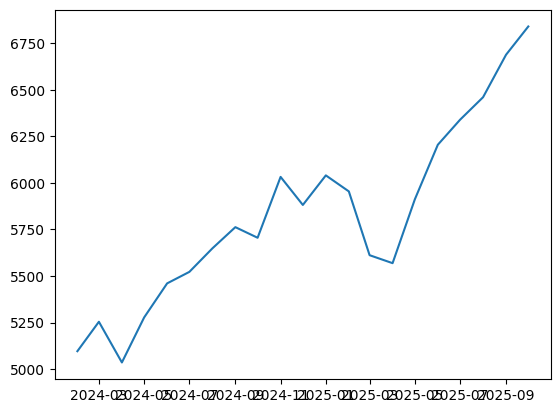

In [126]:
plt.figure()

plt.plot(aranceles_trump['Date'], aranceles_trump['Close'])

plt.show()

In [127]:
print(100/1500)

0.06666666666666667


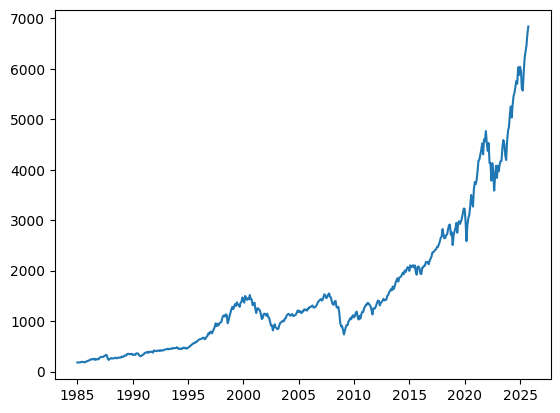

In [128]:
plt.figure()

plt.plot(df['Date'], df['Close'])

plt.show()